In [1]:
import numpy as np
%matplotlib inline
from sfo import SFO
from devito import configuration
configuration['log-level'] = 'WARNING'

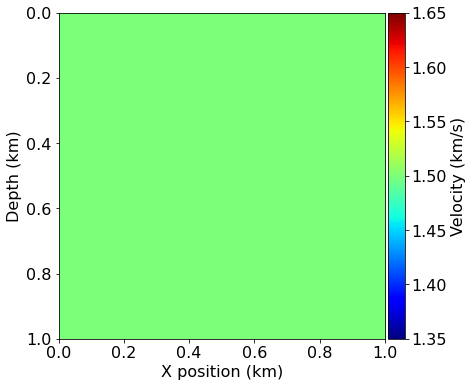

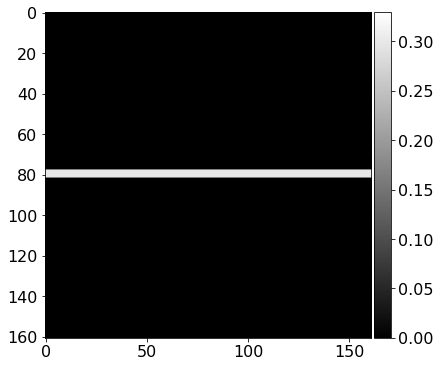

In [2]:
from examples.seismic import plot_image, plot_shotrecord
from examples.seismic import Model, plot_velocity
from scipy import ndimage

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations
nbl = 30
space_order = 4

vp = 1.5*np.ones(shape)

model0 = Model(space_order=space_order, vp=vp, origin=origin, shape=shape,
                dtype=np.float32, spacing=spacing, nbl=nbl, bcs="damp")

# Compute initial born perturbation from m - m0
dm = np.zeros(model0.grid.shape, dtype=np.float32)
dm[:,nbl+48:nbl+52] = 0.3

plot_velocity(model0)
plot_image(dm)

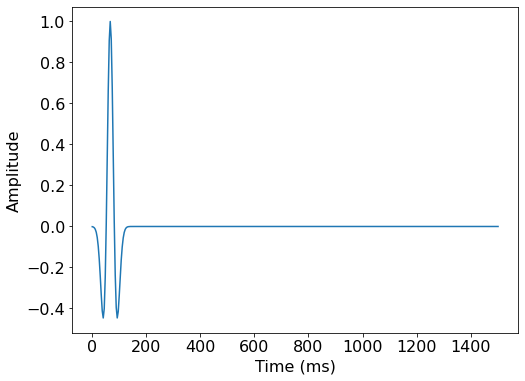

In [3]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

nshots = 100
nreceivers = 101
t0 = 0.
tn = 1500.
f0 = 0.015

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model0.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model0.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry
geometry = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

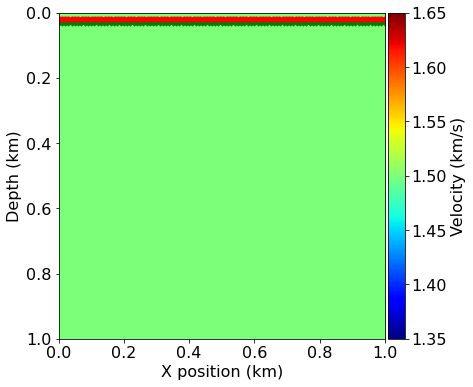

In [4]:
# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model0.domain_size[0], num=nshots)
source_locations[:, 1] = 20.

plot_velocity(model0, source=source_locations, receiver=rec_coordinates)

In [5]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model0, geometry, space_order=space_order)

In [6]:
#generates true data once
dobs = np.empty((geometry.nt*nreceivers,nshots), dtype=np.float32)

for i in range(nshots):
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]
        
    # Generate synthetic data from true model
    true_d, _, _, _ = solver.born(dm, vp=model0.vp)
    
    dobs[:,i] = np.reshape(true_d.data[:,:], geometry.nt*nreceivers) 

In [7]:
#plot_image(np.transpose(np.reshape(dobs[:,0],(geometry.nt,geometry.nrec))))
#plot_image(np.transpose(np.reshape(dobs[:,99],(geometry.nt,geometry.nrec))))

In [8]:
from devito import Function, TimeFunction
from examples.seismic import Receiver

def f_df(m, data_list):   
    
    nsrc_batch = len(data[1])
    
    dobs = data_list[0].reshape((geometry.nt,geometry.nrec,nsrc_batch))
   
    # Create symbols to hold the gradient and residual
    grad = Function(name="grad", grid=model0.grid)
    rfl = Function(name="rfl", grid=model0.grid)
    rfl.data[:,:] = np.reshape(m, model0.grid.shape) 
    
    residual = Receiver(name='rec', grid=model0.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    objective = 0.   
    
    #plot_image(rfl.data)
        
    for i in range(nsrc_batch):
        # Update source location
        geometry.src_positions[0, :] = source_locations[data_list[1][i], :] 
        
            
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=model0.vp, save=True)
                
        # Compute smooth data and full forward wavefield u0
        smooth_d, _, _, _ = solver.born(rfl, vp=model0.vp)
        
        # Compute gradient from data residual and update objective function 
        residual.data[:] = smooth_d.data[:] - dobs[:,:,i]
        
        #if geometry.src_positions[0, :][0] < 10.:
        #plot_shotrecord(dobs[:,:,i], model0, t0, tn)
        #plot_shotrecord(smooth_d.data, model0, t0, tn)
            
                
        objective += .5*np.linalg.norm(residual.data.flatten())**2        
        solver.gradient(rec=residual, u=u0, vp=model0.vp, grad=grad)        
             
    return objective, grad.data.flatten()


In [9]:
# set model and training data parameters
M = geometry.nt*geometry.nrec                 # number visible units
D = 100                                       # full data batch size
N = 25                                        # number minibatches
B = D//N                                      # batch size

# generate full training data
data_list = [dobs, range(nshots)]

# create the array of subfunction specific arguments
indices = np.arange(D)
np.random.shuffle(indices)

sub_refs = []
for i in range(N):
    start = i*B
    stop  = (i+1)*B
    shots = indices[start:stop]
    data = np.zeros((geometry.nt*geometry.nrec,B),dtype=np.float32)
    for j in range(B):
        data[:,j] = dobs[:,shots[j]]

    sub_refs.append([data,shots])


In [10]:
#s = 2
#nb = 20
#plot_image(np.transpose(np.reshape(sub_refs[nb][0][:,s],(geometry.nt,geometry.nrec))))
#sub_refs[nb][1]

In [11]:
# initialize parameters
J = model0.grid.shape[0]*model0.grid.shape[1]
theta_init = np.zeros(J, dtype=np.float32)

# initialize the optimizer
optimizer = SFO(f_df, theta_init, sub_refs)

# run the optimizer for 1 pass through the data
theta = optimizer.optimize(num_passes=1)

pass 0.0, step 0,
active 2/25, sfo time 0.00920248031616211 s, func time 1.6951420307159424 s, f 781.5081274243257, <f> 781.5081274243257
pass 0.04, step 1,
active 2/25, sfo time 0.016057491302490234 s, func time 2.181447744369507 s, f 780.5962787967383, <f> 780.5962787967383
pass 0.08, step 2,
active 2/25, sfo time 0.0211794376373291 s, func time 2.5457897186279297 s, f 747.2982973037324, <f> 763.9472880502353
pass 0.12, step 3,
active 3/25, sfo time 0.02767324447631836 s, func time 2.9719417095184326 s, f 740.5513622716135, <f> 760.5738205341759
pass 0.16, step 4,
active 4/25, sfo time 0.03875303268432617 s, func time 3.7628982067108154 s, f 765.2112772674354, <f> 762.1196394452624
pass 0.24, step 5,
active 5/25, sfo time 0.04940915107727051 s, func time 4.603206396102905 s, f 931.8100096635353, <f> 804.5422319998306
pass 0.32, step 6,
active 5/25, sfo time 0.054959774017333984 s, func time 5.001978397369385 s, f 661.689033393126, <f> 775.9715922784897
pass 0.36, step 7,
active 5/25,

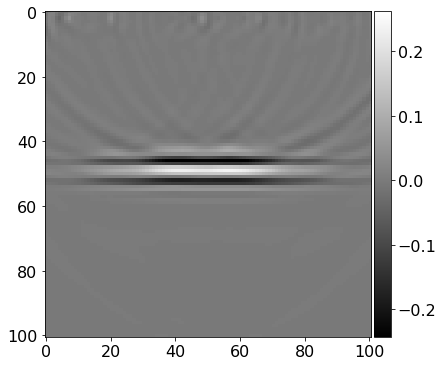

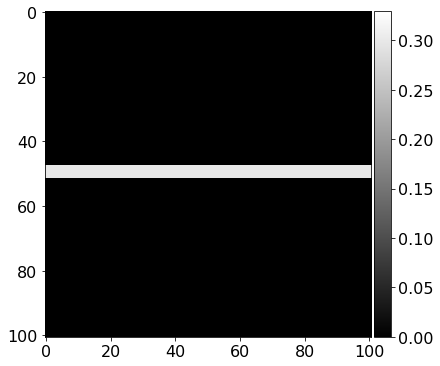

In [12]:
plot_image(theta.reshape((model0.grid.shape[0],model0.grid.shape[1]))[nbl:-nbl,nbl:-nbl])
plot_image(dm[nbl:-nbl,nbl:-nbl])

Text(0.5, 1.0, 'Convergence Trace')

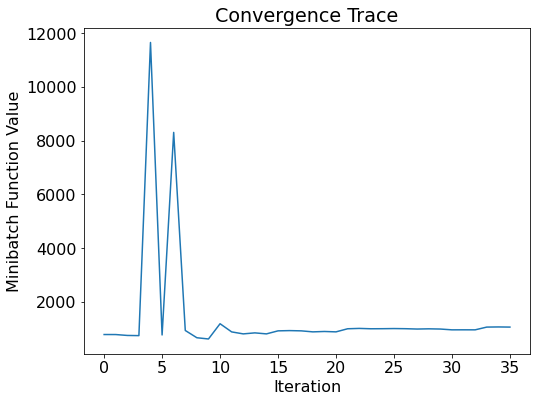

In [13]:
import matplotlib.pyplot as plt
plt.plot(np.array(optimizer.hist_f_flat))
plt.xlabel('Iteration')
plt.ylabel('Minibatch Function Value')
plt.title('Convergence Trace')